In [1]:
import pandas as pd
import os
from glob import glob
import json
import re
import numpy as np

In [2]:
# set working directory
os.chdir('/project/cper_neon_aop/cper_pdog_uas')

idx = 0
for d in glob('./cnn_results_*'):
    f_list = glob(d + '/best_model_*_validation.txt')
    for f in f_list:
        with open(f, 'r') as src:
            val_dat = src.read()
            df_tmp = pd.DataFrame(json.loads(re.sub('nan', '"nan"', '"'.join(val_dat.split("'")))), index=[0])
            df_tmp['model'] = d.split('_')[-1]
            df_tmp['inputs'] = ','.join(os.path.basename(f).split('_')[2:-1])
            df_tmp['min_rp'] = df_tmp[['precision', 'recall']].min(axis=1)
            if idx == 0:
                df_val = df_tmp
            else:
                df_val = pd.concat([df_val, df_tmp])
            idx += 1

In [3]:
df_val.sort_values('fscore', ascending=False).head(20)

,mccloss,iou_score,accuracy,precision,recall,fscore,best_epoch,model,inputs,min_rp
0,0.716281,0.778953,0.992279,0.914091,0.849661,0.824967,24,deeplabplus,tpi,0.849661
0,0.724788,0.756679,0.991639,0.924592,0.816858,0.803589,8,fpn,"tpi,ndvi",0.816858
0,0.727273,0.755453,0.992174,0.933166,0.809261,0.799006,20,deeplabplus,"tpi,ndvi",0.809261
0,0.726172,0.748611,0.992096,0.906073,0.829275,0.791648,11,fpn,tpi,0.829275
0,0.720298,0.738963,0.990393,0.885300,0.815281,0.782640,35,fpn,"rgb,ndvi,dsm",0.815281
0,0.732663,0.735013,0.990915,0.881887,0.825211,0.775786,24,fpn,"rgb,tpi,shade",0.825211
0,0.776798,0.732622,0.989078,0.868805,0.817503,0.775187,29,manet,"rgb,shade,dsm",0.817503
0,0.736336,0.719214,0.991578,0.869480,0.837124,0.764645,20,manet,tpi,0.837124
0,0.777418,0.727237,0.990970,0.913976,0.798996,0.762081,16,manet,"tpi,ndvi",0.798996
0,0.757074,0.715348,0.990812,0.879335,0.802871,0.761026,12,deeplabplus,rgb,0.802871


## Test best model

### Set parameters and datasets

In [4]:
from random import sample, seed

In [5]:
model_fnl = 'fpn'
inputs_fnl = ['rgb','tpi','shade']

In [6]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'# 'cpu'# 

In [7]:
# set directories for training data and labels
DATA_FOLDER = './cnn_train_images/{}_{}.tif'
LABEL_FOLDER = './cnn_train_labels/{}_labels.tif'

In [8]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [9]:
# get all ids to be used
label_files = glob(LABEL_FOLDER.replace('{}', '*'))
all_ids = [re.sub('_labels.tif', '', os.path.basename(f)) for f in label_files]
all_tiles = list(set(['_'.join(y.split('_')[-3:]) for y in all_ids]))

In [10]:
# separate training and test data and get paths to files
all_files = glob(DATA_FOLDER.replace('{}', '*'))
all_train_tiles = [x for x in df_tiles.apply(lambda x: '_'.join([x.Pasture, x.Tile]) if x.Train == 1 else '', axis=1) if x != '' and x in all_tiles]
test_tiles = list(set(all_tiles) - set(all_train_tiles))

all_train_ids = [x for x in all_ids if '_'.join(x.split('_')[-3:]) in all_train_tiles]
test_ids = list(set(all_ids) - set(all_train_ids))

seed(321)
valid_ids = sample(all_train_ids, int(np.ceil(len(all_train_ids)*0.3)))
train_ids = list(set(all_train_ids) - set(valid_ids))

train_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in train_ids]
valid_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in valid_ids]
test_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in test_ids]

### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [12]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dsm': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'},
        'ndvi': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='uint8')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        else:
            image = image.transpose(2, 0, 1).astype('float32')
            mask = mask.transpose(2, 0, 1).astype('float32')
        return image, mask
        
    def __len__(self):
        return len(self.ids)




### Test the best model

In [13]:
# load best saved checkpoint
best_model = torch.load('./cnn_results_' + model_fnl + '/best_model_' + '_'.join(inputs_fnl) + '.pth')

In [14]:
# test dataset without transformations for image visualization
test_dataset = Dataset(
    test_ids,
    inputs_fnl,
    DATA_FOLDER,
    LABEL_FOLDER,
    #preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [15]:
#next(iter(test_dataloader))[0]#.shape#.squeeze().transpose(0, 2).transpose(1, 2).shape

In [16]:
best_model.eval()

with torch.no_grad():
    prediction = best_model.forward(next(iter(test_dataloader))[0].cuda())

In [17]:
#prediction

In [18]:
test_metrics = [
    utils.metrics.IoU(threshold=0.5),
    utils.metrics.Accuracy(threshold=0.5),
    utils.metrics.Precision(threshold=0.5),
    utils.metrics.Recall(threshold=0.5),
    utils.metrics.Fscore(threshold=0.5)
]

loss = smp.losses.MCCLoss()
loss.__name__ = 'mccloss'

In [79]:
# evaluate model on test set
test_epoch = utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=test_metrics,
    device=DEVICE,
    verbose=True,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 539/539 [01:48<00:00,  4.95it/s, mccloss - 0.612, iou_score - 0.6605, accuracy - 0.9871, precision - 0.8307, recall - 0.8009, fscore - 0.7317] 


In [80]:
logs

{'mccloss': 0.6119704202287491,
 'iou_score': 0.6604947584609613,
 'accuracy': 0.9870962336908244,
 'precision': 0.830706588963533,
 'recall': 0.800908957516876,
 'fscore': 0.7316879255057063}

### Quantify and Visualize Test Data Predictions

In [19]:
import itertools
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
import shapely.wkt as wkt
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torch.nn as nn

In [20]:
# helper function for data visualization
def visualize(show=True, write=False, path=None, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if show:
        plt.show()
    if write:
        plt.savefig(path)
    if not show and write:
        plt.close()

In [21]:
test_dataset_vis = Dataset(
    test_ids,
    inputs_fnl,
    DATA_FOLDER,
    LABEL_FOLDER,
    classes=CLASSES)

In [22]:
df_polys['geometry'] = df_polys.geometry.apply(lambda x: Polygon(wkt.loads(x)))
gdf_polys = gpd.GeoDataFrame(df_polys, geometry='geometry')
gdf_polys = gdf_polys.set_crs(32613)

In [23]:
df_tiles[df_tiles['ID'] == 'CN_29']

,Unnamed: 0,ID,Pasture,Tile,min_x,min_y,Type,Train,Digitize,max_x,max_y,img_group,Poly_ID,path_pre,trainer
66,110,CN_29,CN,random_20,520432.0,4516631.0,random,0,1,520462.0,4516661.0,group_3,None,train_tiles/CN_random/CN_random_20_,David


In [24]:
gdf_polys

,Unnamed: 0,orig_index,Comment,Tile,Trainer,geometry,group,subID
0,0,0,NaN,CN_50,Sean,"POLYGON ((519835.548 4516699.658, 519836.043 4...",random,0
1,1,1,NaN,CN_50,Sean,"POLYGON ((519837.998 4516708.403, 519838.603 4...",random,1
2,2,2,NaN,CN_50,Sean,"POLYGON ((519828.005 4516706.137, 519828.336 4...",random,2
3,3,3,NaN,CN_50,Sean,"POLYGON ((519849.530 4516703.545, 519850.209 4...",random,3
4,4,4,NaN,CN_50,Sean,"POLYGON ((519849.728 4516697.939, 519850.294 4...",random,4
...,...,...,...,...,...,...,...,...
374,448,64,NaN,22W_14,David,"POLYGON ((519588.080 4518187.215, 519589.099 4...",random,3
375,449,65,NaN,22W_14,David,"POLYGON ((519587.764 4518179.192, 519589.064 4...",random,4
376,450,66,NaN,22W_0,David,"POLYGON ((519853.938 4519328.380, 519854.331 4...",random,0
377,451,67,NaN,22W_0,David,"POLYGON ((519860.298 4519320.625, 519860.859 4...",random,1


In [87]:
precision_list = []
recall_list = []

burrow_ct_gt = []
burrow_ct_pred = []
tile_id_list = []

for ID in df_tiles['ID'][(df_tiles['Train'] == 0) &
                         (df_tiles['Digitize'] == 1) &
                         (df_tiles['trainer'] != 'Nick')]:
    if all(df_tiles[df_tiles['ID'] == ID]['Train'] == 1):
        continue
    else:
        print(ID)
        # get the path base to the imagery associated with the training tile
        tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
        # get the x/y coordinates of the bounding box for the training polygon within the tile
        box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
        box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
        # get the box coordinate pairs
        ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
        # create a polygon from the coordinate pairs
        tile_geom = Polygon([ll, ul, ur, lr])
        # create the full path to the RGB image of the training tile
        rgb_path = tilePATH + 'rgb.tif'
        with rio.open(rgb_path) as src_rgb:   
            profile_rgb = src_rgb.meta
            rgb_out, transform_out = mask.mask(src_rgb,
                                               [tile_geom],
                                               crop=True)
            rgb_out = rgb_out.astype('int')
            #rgb_out = rgb_out[:, -win_size:, :win_size]
            #show(rgb_out)
            ll_i = src_rgb.index(*ll)
            ur_i = src_rgb.index(*ur)
            gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
            if len(gdf_polys_sub) > 0:
                label_mask = rasterize(gdf_polys_sub.geometry, 
                                  out_shape=rgb_out.shape[1:], transform=transform_out,
                                  default_value=1)
            else:
                 label_mask = np.zeros_like(rgb_out[0, :, :])   
            #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
            profile_rgb.update({'dtype': 'int16',
                                'width': rgb_out.shape[0],
                                'height': rgb_out.shape[1],
                                'transform': transform_out})
            profile_single = profile_rgb.copy()
            profile_single.update({'count': 1})
            profile_single_float = profile_single.copy()
            profile_single_float.update({'dtype': 'float64'})
            #show(label)

        n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
        n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

        pr_mask = np.empty_like(rgb_out[0, :, :])
        image_dict = {}
        for suffix in inputs_fnl:
            with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
                i_out = src_i.read(out_shape=(
                    src_i.count,
                    src_rgb.meta['width'],
                    src_rgb.meta['height']),
                                   resampling=Resampling.bilinear)
                image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
        image_sub_dict = {}
        for r in range(n_row_chunks):
            if (r + 1) * 256 > rgb_out.shape[1]:
                r_min = rgb_out.shape[1] - 256
                r_max = rgb_out.shape[1]
            else:
                r_min = r * 256
                r_max = (r + 1) * 256
            for c in range(n_col_chunks):
                if (c + 1) * 256 > rgb_out.shape[2]:
                    c_min = rgb_out.shape[2] - 256
                    c_max = rgb_out.shape[2]
                else:
                    c_min = c * 256
                    c_max = (c + 1) * 256
                for k in image_dict:
                    image_sub_dict[k] = image_dict[k][:, r_min:r_max, c_min:c_max].astype('float32')
                if 'rgb' in inputs_fnl:
                    image_sub_dict['rgb'] = rgb_out[:, r_min:r_max, c_min:c_max].astype('float32')
                image_list = [image_sub_dict[i] for i in inputs_fnl]
                image_out = np.concatenate(image_list, axis=0)
                x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                if type(best_model) == nn.DataParallel:
                    pr_mask[r_min:r_max, c_min:c_max] = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                else:
                    pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5

        # get regions and properties of the ground truth and predictions
        label_labels = label(label_mask)
        label_regions = regionprops(label_labels)
        pr_labels = label(pr_mask)
        pr_regions = regionprops(pr_labels)
        
        r_ct_pred = 0
        for r in pr_regions:
            if r.area*src_rgb.meta['transform'][0]**2 > 0.05:
                y_pr, x_pr = r.centroid
                precision_list.append(label_mask[int(y_pr), int(x_pr)])
                r_ct_pred += 1

        r_ct_gt = 0
        for r in label_regions:
            y_label, x_label = r.centroid
            recall_list.append(pr_mask[int(y_label), int(x_label)])
            r_ct_gt += 1
        burrow_ct_gt.append(r_ct_gt)
        burrow_ct_pred.append(r_ct_pred)
        tile_id_list.append(ID)

        #visualize(show=False,
        #          write=False,
        #          path='./cnn_results/test_predictions/' + 'pred_' + ID + '.png',
        #          image=rgb_out.transpose((1, 2, 0)), 
        #          ground_truth_mask=label.squeeze(), 
        #          predicted_mask=pr_mask.squeeze()
        #    )
        #plt.close()

5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54
CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38
22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16


In [88]:
precision = np.sum(precision_list) / len(precision_list)
recall = np.sum(recall_list) / len(recall_list)
fscore = (2 * precision * recall) / (precision + recall)
corr = np.corrcoef(burrow_ct_gt, burrow_ct_pred)[0, 1]

In [89]:
print('--- Results for ' + str(len(tile_id_list)) + ' test tiles (excluding predicted burrows < 0.05 m^2) ---')
print('precision: ' + str(round(precision, 2)))
print('recall: ' + str(round(recall, 2)))
print('f-score: ' + str(round(fscore, 2)))
print('burrow count correlation: ' + str(round(corr, 2)))

--- Results for 44 test tiles (excluding predicted burrows < 0.05 m^2) ---
precision: 0.67
recall: 0.75
f-score: 0.71
burrow count correlation: 0.82


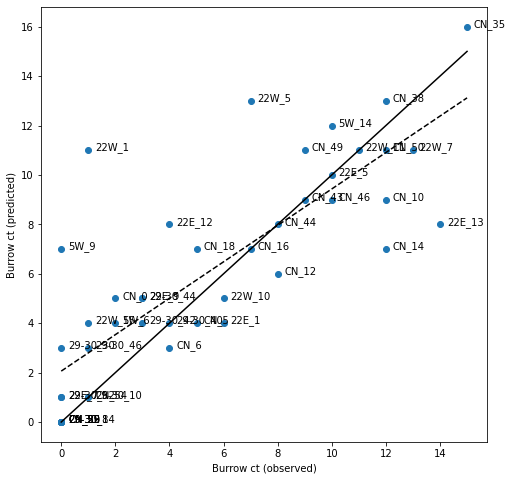

In [90]:
plt.figure(figsize=(8, 8))
plt.scatter(x=burrow_ct_gt, y=burrow_ct_pred)
plt.xlabel('Burrow ct (observed)')
plt.ylabel('Burrow ct (predicted)')
plt.plot(np.arange(0, 16), np.arange(0, 16), c='black')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(burrow_ct_gt, burrow_ct_pred, 1)
#add linear regression line to scatterplot 
plt.plot(np.arange(0, 16), m*np.arange(0, 16)+b, 
         linestyle='dashed', c='black')

if True:
    for i in range(len(burrow_ct_gt)):
        plt.text(x=burrow_ct_gt[i]+0.25,
                 y=burrow_ct_pred[i],
                 s=tile_id_list[i])

In [34]:
np.array(tile_id_list)[[i == 0 for i in burrow_ct_gt]]

array(['5W_9', 'CN_26', '29-30_8', 'CN_52', '29-30_32', '22E_7', 'CN_29',
       '29-30_30', '29-30_14', 'CN_59'], dtype='<U8')

29-30_30
0


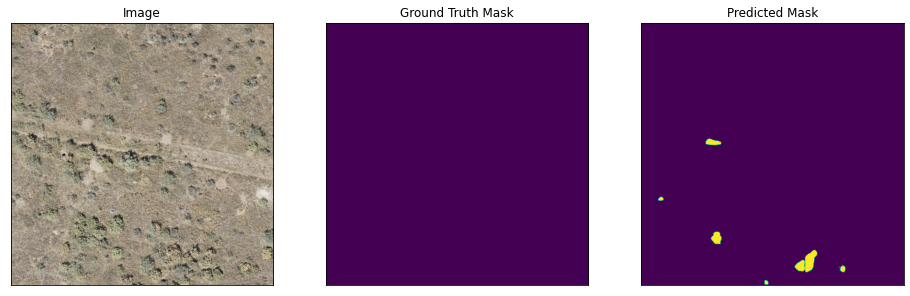

In [36]:
ID = '29-30_30'
print(ID)
# get the path base to the imagery associated with the training tile
tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
tile_geom = Polygon([ll, ul, ur, lr])
# create the full path to the RGB image of the training tile
rgb_path = tilePATH + 'rgb.tif'
with rio.open(rgb_path) as src_rgb:   
    profile_rgb = src_rgb.meta
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    rgb_out = rgb_out.astype('int')
    #rgb_out = rgb_out[:, -win_size:, :win_size]
    #show(rgb_out)
    ll_i = src_rgb.index(*ll)
    ur_i = src_rgb.index(*ur)

    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
    print(len(gdf_polys_sub))
    if len(gdf_polys_sub) > 0:
        label_mask = rasterize(gdf_polys_sub.geometry, 
                          out_shape=rgb_out.shape[1:], transform=transform_out,
                          default_value=1)
    else:
         label_mask = np.zeros_like(rgb_out[0, :, :])   
    #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
    profile_rgb.update({'dtype': 'int16',
                        'width': rgb_out.shape[0],
                        'height': rgb_out.shape[1],
                        'transform': transform_out})
    profile_single = profile_rgb.copy()
    profile_single.update({'count': 1})
    profile_single_float = profile_single.copy()
    profile_single_float.update({'dtype': 'float64'})
    #show(label)

n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

pr_mask = np.empty_like(rgb_out[0, :, :])
image_dict = {}
for suffix in inputs_fnl:
    with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
        i_out = src_i.read(out_shape=(
            src_i.count,
            src_rgb.meta['width'],
            src_rgb.meta['height']),
                           resampling=Resampling.bilinear)
        image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
image_sub_dict = {}
for r in range(n_row_chunks):
    if (r + 1) * 256 > rgb_out.shape[1]:
        r_min = rgb_out.shape[1] - 256
        r_max = rgb_out.shape[1]
    else:
        r_min = r * 256
        r_max = (r + 1) * 256
    for c in range(n_col_chunks):
        if (c + 1) * 256 > rgb_out.shape[2]:
            c_min = rgb_out.shape[2] - 256
            c_max = rgb_out.shape[2]
        else:
            c_min = c * 256
            c_max = (c + 1) * 256
        for k in image_dict:
            image_sub_dict[k] = image_dict[k][:, r_min:r_max, c_min:c_max].astype('float32')
        if 'rgb' in inputs_fnl:
            image_sub_dict['rgb'] = rgb_out[:, r_min:r_max, c_min:c_max].astype('float32')
        image_list = [image_sub_dict[i] for i in inputs_fnl]
        image_out = np.concatenate(image_list, axis=0)
        x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
        if type(best_model) == nn.DataParallel:
            pr_mask[r_min:r_max, c_min:c_max] = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
        else:
            pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5

# get regions and properties of the ground truth and predictions
label_labels = label(label_mask)
label_regions = regionprops(label_labels)
pr_labels = label(pr_mask)
pr_regions = regionprops(pr_labels)

r_ct_pred = 0
for r in pr_regions:
    if r.area*src_rgb.meta['transform'][0]**2 > 0.01:
        y_pr, x_pr = r.centroid
        precision_tmp = (label_mask[int(y_pr), int(x_pr)])
        r_ct_pred += 1

r_ct_gt = 0
for r in label_regions:
    y_label, x_label = r.centroid
    recall_tmp = (pr_mask[int(y_label), int(x_label)])
    r_ct_gt += 1

visualize(show=True,
          write=False,
          path='./cnn_results/test_predictions/' + 'pred_' + ID + '.png',
          image=rgb_out.transpose((1, 2, 0)), 
          ground_truth_mask=label_mask.squeeze(), 
          predicted_mask=pr_mask.squeeze()
    )


In [ ]:
#if not os.path.exists('./cnn_results_' + model_fnl + '/test_predictions' + '_'.join(inputs_fnl)):
#    os.mkdir('./cnn_results_' + model_fnl + '/test_predictions' + '_'.join(inputs_fnl))
for i in range(10):
    n = np.random.choice(len(test_dataset))
    #n = i
    get_vis = test_dataset_vis[n]
    image_vis = test_dataset_vis.image_dict['rgb'].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(show=True,
                  write=False,
                  path='./cnn_results/test_predictions/' + 'pred_' + test_dataset_vis.ids[n] + '.png',
                  image=image_vis, 
                  ground_truth_mask=gt_mask, 
                  predicted_mask=pr_mask.squeeze()
            )

CN_50


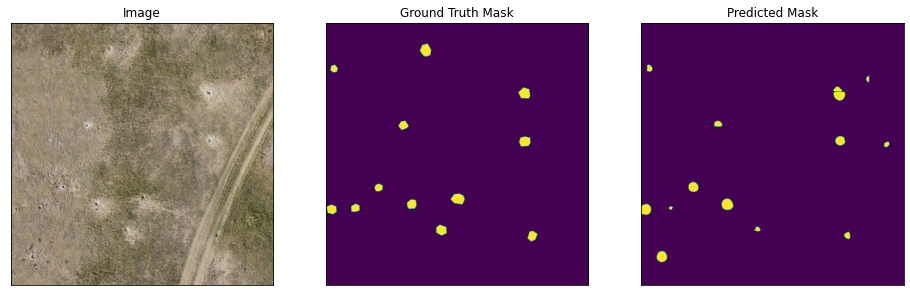

In [123]:
precision_list_sub = []
recall_list_sub = []
ID = 'CN_50'
if not all(df_tiles[df_tiles['ID'] == ID]['Train'] == 1):
    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
    print(ID)
    # get the path base to the imagery associated with the training tile
    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
    # get the x/y coordinates of the bounding box for the training polygon within the tile
    box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
    box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
    # get the box coordinate pairs
    ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
    # create a polygon from the coordinate pairs
    tile_geom = Polygon([ll, ul, ur, lr])
    # create the full path to the RGB image of the training tile
    rgb_path = tilePATH + 'rgb.tif'
    with rio.open(rgb_path) as src_rgb:   
        profile_rgb = src_rgb.meta
        rgb_out, transform_out = mask.mask(src_rgb,
                                           [tile_geom],
                                           crop=True)
        rgb_out = rgb_out.astype('int')
        #rgb_out = rgb_out[:, -win_size:, :win_size]
        #show(rgb_out)
        ll_i = src_rgb.index(*ll)
        ur_i = src_rgb.index(*ur)

        label_mask = rasterize(gdf_polys_sub.geometry, 
                          out_shape=rgb_out.shape[1:], transform=transform_out,
                          default_value=1)
        #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
        profile_rgb.update({'dtype': 'int16',
                            'width': rgb_out.shape[0],
                            'height': rgb_out.shape[1],
                            'transform': transform_out})
        profile_single = profile_rgb.copy()
        profile_single.update({'count': 1})
        profile_single_float = profile_single.copy()
        profile_single_float.update({'dtype': 'float64'})
        #show(label)

    n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
    n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

    pr_mask = np.zeros_like(rgb_out[0, :, :])
    image_dict = {}
    for suffix in inputs_fnl:
        with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
            i_out = src_i.read(out_shape=(
                src_i.count,
                src_rgb.meta['width'],
                src_rgb.meta['height']),
                               resampling=Resampling.bilinear)
            image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
    image_sub_dict = {}
    for r in range(n_row_chunks):
        if (r + 1) * 256 > rgb_out.shape[1]:
            r_min = rgb_out.shape[1] - 256
            r_max = rgb_out.shape[1]
        else:
            r_min = r * 256
            r_max = (r + 1) * 256
        for c in range(n_col_chunks):
            if (c + 1) * 256 > rgb_out.shape[2]:
                c_min = rgb_out.shape[2] - 256
                c_max = rgb_out.shape[2]
            else:
                c_min = c * 256
                c_max = (c + 1) * 256
            for k in image_dict:
                image_sub_dict[k] = image_dict[k][:, r_min:r_max, c_min:c_max].astype('float32')
            if 'rgb' in inputs_fnl:
                image_sub_dict['rgb'] = rgb_out[:, r_min:r_max, c_min:c_max].astype('float32')
            image_list = [image_sub_dict[i] for i in inputs_fnl]
            image_out = np.concatenate(image_list, axis=0)
            x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
            pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
            #if True:
            #    break
        #if True:
        #    break
        #    print('done')

    # get regions and properties of the ground truth and predictions
    label_labels = label(label_mask)
    label_regions = regionprops(label_labels)
    pr_labels = label(pr_mask)
    pr_regions = regionprops(pr_labels)
    
    for r in pr_regions:
        if r.area*src_rgb.meta['transform'][0]**2 > 0.01:
            y_pr, x_pr = r.centroid
            precision_list_sub.append(label_mask[int(y_pr), int(x_pr)])

    for r in label_regions:
        y_label, x_label = r.centroid
        recall_list_sub.append(pr_mask[int(y_label), int(x_label)])  
    
    
    visualize(show=True,
              write=False,
              image=rgb_out.transpose((1, 2, 0)), 
              ground_truth_mask=label_mask.squeeze(), 
              predicted_mask=pr_mask.squeeze()
        )

In [124]:
precision_sub = np.sum(precision_list_sub) / len(precision_list_sub)
recall_sub = np.sum(recall_list_sub) / len(recall_list_sub)
fscore_sub = (2 * precision_sub * recall_sub) / (precision_sub + recall_sub)

In [125]:
print('precision: ' + str(round(precision_sub, 2)))
print('recall: ' + str(round(recall_sub, 2)))
print('f-score: ' + str(round(fscore_sub, 2)))

precision: 0.79
recall: 0.83
f-score: 0.81


In [99]:
for r in label_regions:
    print(r.centroid)

(208.0, 245.1888775361261)
(408.4257377842284, 1367.9305757135946)
(924.8004747277297, 1506.991622451829)
(1306.0253290290539, 210.1131114973926)


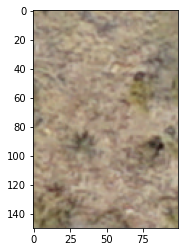

In [106]:
plt.imshow(rgb_out[:, 1200:1350, 150:250].transpose(1, 2, 0))

In [110]:
image_dict['shade'].shape

(1, 2039, 2039)

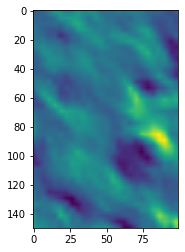

In [112]:
plt.imshow(image_dict['shade'][:, 1200:1350, 150:250].squeeze())

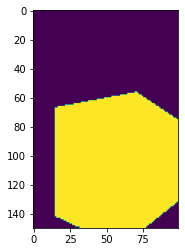

In [107]:
plt.imshow(label_mask[1200:1350, 150:250])

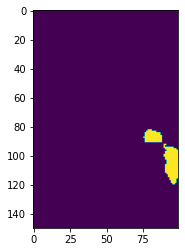

In [103]:
plt.imshow(pr_mask[1200:1350, 150:250])

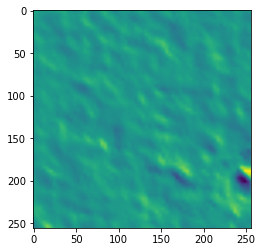

In [64]:
plt.imshow(image_out[3, :, :])

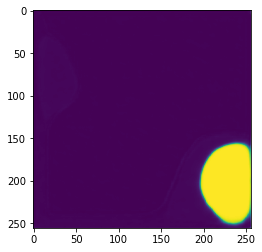

In [81]:
plt.imshow(best_model.predict(x_tensor).cpu().detach().numpy().squeeze())

In [85]:
pr_mask[r_min:r_max, c_min:c_max].dtype# = best_model.predict(x_tensor).cpu().detach().numpy().squeeze()

dtype('int64')

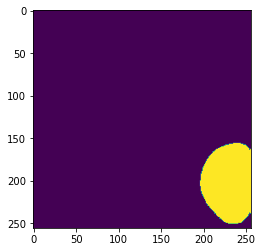

In [88]:
plt.imshow(pr_mask[r_min:r_max, c_min:c_max] > 0.5)

In [81]:


label_labels = label(label_mask)
label_regions = regionprops(label_labels)

pr_labels = label(pr_mask)
pr_regions = regionprops(pr_labels)

In [86]:
precision_list = []
for r in pr_regions:
    if r.area*src_rgb.meta['transform'][0]**2 > 0.01:
        y_pr, x_pr = r.centroid
        precision_list.append(label_mask[int(y_pr), int(x_pr)])

recall_list = []
for r in label_regions:
    y_label, x_label = r.centroid
    recall_list.append(pr_mask[int(y_label), int(x_label)])        

In [87]:
precision_list

[1, 1, 1]

In [88]:
recall_list

[1, 0, 1, 0]

In [74]:
src_rgb.meta['transform'][0]**2

0.0002166579681103332

In [ ]:
ID = 'CN_6'
gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
print(ID)
# get the path base to the imagery associated with the training tile
tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
tile_geom = Polygon([ll, ul, ur, lr])
# create the full path to the RGB image of the training tile
rgb_path = tilePATH + 'rgb.tif'
with rio.open(rgb_path) as src_rgb:   
    profile_rgb = src_rgb.meta
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    rgb_out = rgb_out.astype('int')
    #rgb_out = rgb_out[:, -win_size:, :win_size]
    show(rgb_out)
    ll_i = src_rgb.index(*ll)
    ur_i = src_rgb.index(*ur)

    label = rasterize(gdf_polys_sub.geometry, 
                      out_shape=rgb_out.shape[1:], transform=transform_out,
                      default_value=1)
    #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
    profile_rgb.update({'dtype': 'int16',
                        'width': rgb_out.shape[0],
                        'height': rgb_out.shape[1],
                        'transform': transform_out})
    profile_single = profile_rgb.copy()
    profile_single.update({'count': 1})
    profile_single_float = profile_single.copy()
    profile_single_float.update({'dtype': 'float64'})
    show(label)

n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

pr_mask = np.empty_like(rgb_out[0, :, :])
for r in range(n_row_chunks):
    if (r + 1) * 256 > rgb_out.shape[1]:
        r_min = rgb_out.shape[1] - 256
        r_max = rgb_out.shape[1]
    else:
        r_min = r * 256
        r_max = (r + 1) * 256
    for c in range(n_col_chunks):
        if (c + 1) * 256 > rgb_out.shape[2]:
            c_min = rgb_out.shape[2] - 256
            c_max = rgb_out.shape[2]
        else:
            c_min = c * 256
            c_max = (c + 1) * 256
        rgb_sub = rgb_out[:, r_min:r_max, c_min:c_max]
        rgb_image_sub = preprocessing_fn(rgb_sub.transpose((1, 2, 0))).astype('float32').transpose((2, 0, 1))
        x_tensor = torch.from_numpy(rgb_image_sub).to(DEVICE).unsqueeze(0)
        pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().squeeze()

visualize(
        image=rgb_out.transpose((1, 2, 0)), 
        ground_truth_mask=label.squeeze(), 
        predicted_mask=pr_mask.squeeze()
    )

In [44]:
os.path.basename(f).split('_'ascending=-1]

['rgb', 'tpi', 'shade', 'ndvi', 'dsm']

In [38]:
|

SyntaxError: invalid syntax (525519296.py, line 1)